In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [16]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [17]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [82]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
from typing import Any


class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim) -> None:
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX) -> Any:
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]
# -----------------------------------------------------------------------------------------------  
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []
# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers) -> None:
    self.layers = layers

  def __call__(self, x) -> Any:
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [83]:
torch.manual_seed(42);

In [84]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(block_size),
    Linear(n_embd * block_size, n_hidden, bias=False), 
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make the last layer less confident at initialization

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [85]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
print(Xb.shape)
logits = model(Xb)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 12, 15],
        [ 0,  0,  0,  0,  0,  0, 20,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 11]])

In [74]:
# Layer Inspector
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [31]:
model.layers[0].out.shape # the Embedding layer plucks out the 10 values that embedd each character and adds it

torch.Size([4, 8, 10])

In [32]:
model.layers[1].out.shape # since we want our model to work on embeddings, we use the 8x10 = 80 embeddings after our Flatten Layer

torch.Size([4, 80])

In [33]:
model.layers[2].out.shape # Output of Linear Layer

torch.Size([4, 200])

In [36]:
# here's something that we might not expect
(torch.randn(4,80) @ torch.randn(80, 200) + torch.randn(200)).shape # this is what happens in our Linear layer

# but the matrix multiplication can run even on matrices of higher dimensionality, i.e. [4, 5, 80] as long as the last dimension matches the first dimension of the multiplication pair
(torch.randn(4, 5, 80) @ torch.randn(80, 200) + torch.randn(200)).shape
(torch.randn(4, 5, 10, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 10, 200])

In [37]:
# this allows us to not pass ALL characters flattened at the same time
# but we can do something like partitioning them into pairs
# i.e. 1 2 3 4 5 6 7 8
# we might want to transform into bigrams for input
# (1 2) (3 4) (5 6) (7 8) so we have four input bigrams with 2 values each
# so what we want to do is we dont want 8 characters to come in but 2
# Let's assume we have 4 input names and a context window of 8 characters
# We want to divide this context window of 8 characters into 4 bigrams of 2 characters
# i.e. 4 inputs values, 4 pairs of bigrames and each character in a bigram has 10 dimensions, i.e. 2x10 = 20
# for our input matrix of (4, 4, 20)
# --> every 2 consecutive characters are paired in the Flatten layer
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [43]:
# python trick/hack
# get all even values of a list
list(range(10))[::2]

# get all uneven values of a list
list(range(10))[1::2]

# zip consecutive pairs
[(x,y) for x,y in zip(list(range(10))[::2], list(range(10))[1::2])]

[(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]

In [46]:
e = torch.randn(4, 8, 10) # goal: we want this to be (4, 4, 20) where consecutive 10-d vectors get concatenated
e.view(4, -1).shape

# same as above for lists, but with tensors
explicit = torch.concat([e[:, ::2, :], e[:, 1::2, :]], dim=2) # explicit concatenation
explicit.shape

torch.Size([4, 4, 20])

In [48]:
# or simply use .view again
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [21]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.2847


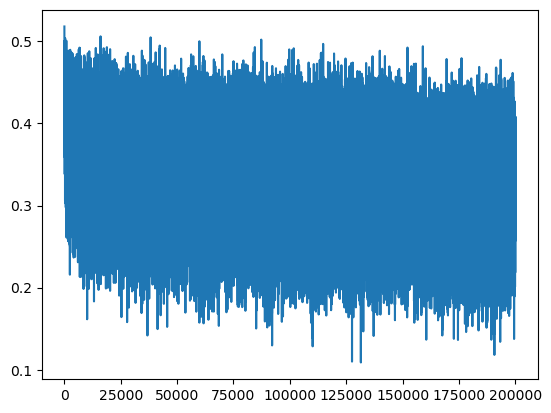

In [11]:
plt.plot(lossi) # at initial solution, this is pretty jagged since we have a small batch size of 32. Therefore, there is a high random chance of a good or a bad batch and this influences the outcome in terms of loss achievable.

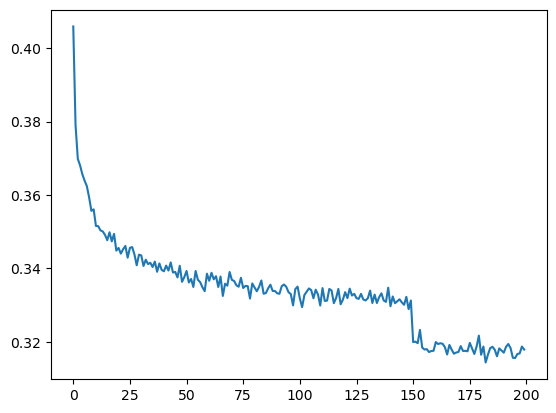

In [12]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [13]:
for layer in model.layers:
    layer.training = False

In [14]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065289974212646


In [15]:
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:

        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

ivon.
fanili.
thoommara.
kelo.
matyn.
leandr.
aleigh.
koldeniah.
prus.
carleen.
jah.
jorra.
alaya.
shonan.
vishylaharia.
juna.
vio.
orven.
mina.
laylee.


In [103]:
n_embd = 24
n_hidden = 128 # changed from 200 to 68 to maintain same number of parameters with WaveNet implementation

# NOTE: This is a simplified hierarchical WaveNet architecture implementation without residual connections
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make the last layer less confident at initialization

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [104]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2762
  10000/ 200000: 2.0777
  20000/ 200000: 1.8276
  30000/ 200000: 2.2829
  40000/ 200000: 1.9790
  50000/ 200000: 2.0214
  60000/ 200000: 2.3288
  70000/ 200000: 2.1512
  80000/ 200000: 1.6621
  90000/ 200000: 1.9631
 100000/ 200000: 1.8876
 110000/ 200000: 1.6177
 120000/ 200000: 1.8483
 130000/ 200000: 2.0961
 140000/ 200000: 1.8482
 150000/ 200000: 2.1948
 160000/ 200000: 2.0468
 170000/ 200000: 1.7397
 180000/ 200000: 1.9758
 190000/ 200000: 1.7094


In [105]:
# Layer Inspector
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


In [106]:
model.layers[3].running_mean.shape # we only want to keep one value per hidden state (here 68) for our running mean

torch.Size([1, 1, 128])

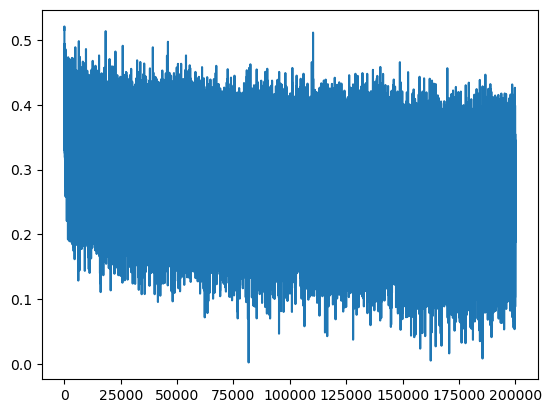

In [107]:
plt.plot(lossi) # at initial solution, this is pretty jagged since we have a small batch size of 32. Therefore, there is a high random chance of a good or a bad batch and this influences the outcome in terms of loss achievable.

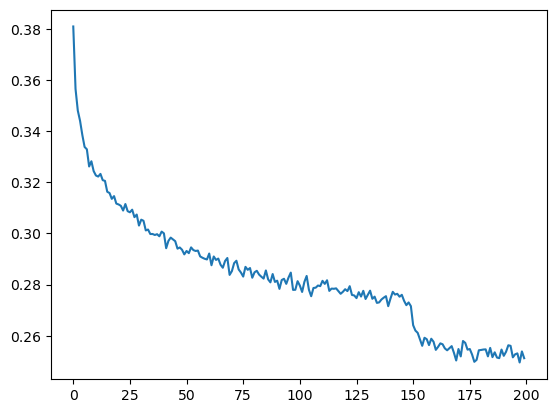

In [108]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [109]:
for layer in model.layers:
    layer.training = False

In [110]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7680652141571045
val 1.9914002418518066


In [111]:
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:

        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

zaheem.
nameela.
ozamar.
jenae.
iram.
mizsy.
adrielle.
xadeel.
marlea.
teah.
kaylin.
graisen.
suraya.
mabbrielle.
anaeri.
lendo.
brandle.
ziki.
kellen.
william.
